In [2]:
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# y_train.shape is 2d, (50000, 1). While Keras is smart enough to handle this
# it's a good idea to flatten the array.
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify = y_train)

Untaring file...


In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

assert(len(X_train)==len(y_train))
#assert(len(X_test)==len(y_test))
assert(len(X_valid)==len(y_valid))

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
#n_test = len(X_test)

# Number of validation examples
n_valid = len(X_valid)

# What's the shape of a traffic sign image?
color_image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
#print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", color_image_shape)
print("Number of classes =", n_classes)

Number of training examples = 35000
Number of validation examples = 15000
Image data shape = (32, 32, 3)
Number of classes = 10


In [4]:
### normalize the data
def normalize_image(image_data):
    # scale grayscale image data
    #min_value = image_data.min()
    #max_value = image_data.max()
    #a = .1
    #b = .9
    #denom = (b-a)/(max_value-min_value)
    #returned_image = np.floor(a + (image_data-min_value)*denom)
    #return returned_image
    return image_data*.95/255 - .5

In [5]:
### convert to grayscale
import cv2

def grayscale(image_data):
    return cv2.cvtColor(image_data, cv2.COLOR_RGB2GRAY)

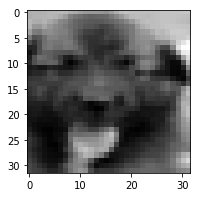

In [6]:
# Preparing data set
import matplotlib.pyplot as plt
%matplotlib inline

# convert to grayscale and normalize image values on training, validation and testing sets
X_train_norm = np.array([normalize_image(grayscale(image)) for image in X_train])
X_train_norm = X_train_norm.reshape(-1, 32, 32, 1)
X_valid_norm = np.array([normalize_image(grayscale(image)) for image in X_valid])
X_valid_norm = X_valid_norm.reshape(-1, 32, 32, 1)
X_test_norm = np.array([normalize_image(grayscale(image)) for image in X_test])
X_test_norm = X_test_norm.reshape(-1, 32, 32, 1)

norm_image_shape = (X_train_norm.shape[1], X_train_norm.shape[2], X_train_norm.shape[3])

image_test = X_train_norm[0].squeeze()
most_frequent_gray = plt.figure(figsize=(3,3))
plt.imshow(image_test*255, cmap='gray')
most_frequent_gray.savefig('most_frequent_gray.png')

In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten
import tensorflow as tf

keep_prob_tensor = tf.placeholder(tf.float32)

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    weights = \
        { 'w_cv1': tf.Variable(tf.truncated_normal(shape=[3,3,norm_image_shape[2],32], mean=mu, stddev=sigma, dtype=tf.float32)), \
          'w_cv2': tf.Variable(tf.truncated_normal(shape=[2,2,32,24], mean=mu, stddev=sigma, dtype=tf.float32)), \
          'w_cv3': tf.Variable(tf.truncated_normal(shape=[2,2,24,16], mean=mu, stddev=sigma, dtype=tf.float32)), \
          'w_fc1': tf.Variable(tf.truncated_normal(shape=[576,120], mean=mu, stddev=sigma, dtype=tf.float32)), \
          'w_fc2': tf.Variable(tf.truncated_normal(shape=[120,84], mean=mu, stddev=sigma, dtype=tf.float32)), \
          'w_out': tf.Variable(tf.truncated_normal(shape=[84,n_classes], mean=mu, stddev=sigma, dtype=tf.float32)) }
#    biases = \
#        { 'b_cv1': tf.Variable(tf.zeros(6)), \
#          'b_cv2': tf.Variable(tf.zeros(16)), \
#          'b_fc1': tf.Variable(tf.zeros(120)), \
#          'b_fc2': tf.Variable(tf.zeros(84)), \
#          'b_out': tf.Variable(tf.zeros(n_classes)) }
    biases = \
        { 'b_cv1': tf.Variable(tf.constant(.1, shape=[32])), \
          'b_cv2': tf.Variable(tf.constant(.1, shape=[24])), \
          'b_cv3': tf.Variable(tf.constant(.1, shape=[16])), \
          'b_fc1': tf.Variable(tf.constant(.1, shape=[120])), \
          'b_fc2': tf.Variable(tf.constant(.1, shape=[84])), \
          'b_out': tf.Variable(tf.constant(.1, shape=[n_classes])) }
    
    strides = \
        { 'st_cv1': [1, 1, 1, 1], \
          'st_cv2': [1, 1, 1, 1] }
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x32.
    conv1 = tf.nn.conv2d(x, weights['w_cv1'], strides=[1, 1, 1, 1], padding='VALID') + biases['b_cv1']

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 30x30x32. Output = 15x15x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 15x15x32. Output = 14x14x24.
    conv2 = tf.nn.conv2d(conv1, weights['w_cv2'], strides=[1, 1, 1, 1], padding='VALID') + biases['b_cv2']

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 14x14x24. Output = 7x7x24.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 7x7x24. Output = 6x6x16.
    conv3 = tf.nn.conv2d(conv2, weights['w_cv3'], strides=[1, 1, 1, 1], padding='VALID') + biases['b_cv3']

    # Activation.
    conv3 = tf.nn.relu(conv3)
    
    # Dropout layer.
    conv3 = tf.nn.dropout(conv3, keep_prob_tensor)

    # Flatten. Input = 6x6x16. Output = 576.
    fc0   = flatten(conv3)

    # Layer 3: Fully Connected. Input = 576. Output = 120.
    fc1   = tf.matmul(fc0, weights['w_fc1']) + biases['b_fc1']

    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, weights['w_fc2']) + biases['b_fc2']

    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout layer.
    fc2 = tf.nn.dropout(fc2, keep_prob_tensor)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, weights['w_out']) + biases['b_out']

    return logits

In [8]:
import tensorflow as tf

# Model hyperparameters
learning_rate = .001
batch_size = 256
keep_prob_train = .6
keep_prob_valid = 1

# Tensorflow features and labels
x = tf.placeholder(tf.float32, (None, norm_image_shape[0], norm_image_shape[1], norm_image_shape[2]))
y = tf.placeholder(tf.int32, (None))

# Cross entropy
one_hot_y = tf.one_hot(y, n_classes)
logits = LeNet(x)
softmax = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

# Optimizer (Adam Optimizer)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

# Accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Saving training
saver = tf.train.Saver()

def evaluate(X_data, y_data, num_examples, keep_prob):
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy, loss = sess.run((accuracy_operation, loss_operation), feed_dict={x: batch_x, y: batch_y, keep_prob_tensor: keep_prob})
        total_accuracy += (accuracy * len(batch_x))
    return (total_accuracy / num_examples, loss)

Initializing model
Training...

Epoch 1 ...
Training Accuracy = 0.259
Validation Accuracy = 0.294

Epoch 2 ...
Training Accuracy = 0.340
Validation Accuracy = 0.375

Epoch 3 ...
Training Accuracy = 0.374
Validation Accuracy = 0.416

Epoch 4 ...
Training Accuracy = 0.402
Validation Accuracy = 0.445

Epoch 5 ...
Training Accuracy = 0.422
Validation Accuracy = 0.456

Epoch 6 ...
Training Accuracy = 0.442
Validation Accuracy = 0.476

Epoch 7 ...
Training Accuracy = 0.455
Validation Accuracy = 0.495

Epoch 8 ...
Training Accuracy = 0.474
Validation Accuracy = 0.514

Epoch 9 ...
Training Accuracy = 0.476
Validation Accuracy = 0.521

Epoch 10 ...
Training Accuracy = 0.494
Validation Accuracy = 0.528

Epoch 11 ...
Training Accuracy = 0.504
Validation Accuracy = 0.540

Epoch 12 ...
Training Accuracy = 0.507
Validation Accuracy = 0.546

Epoch 13 ...
Training Accuracy = 0.518
Validation Accuracy = 0.553

Epoch 14 ...
Training Accuracy = 0.520
Validation Accuracy = 0.554

Epoch 15 ...
Training Acc

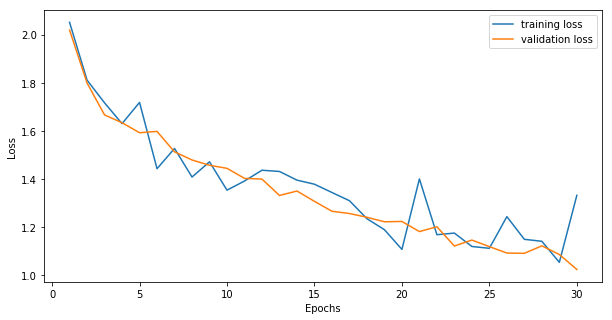

In [9]:
# Tensorflow training session

from sklearn.utils import shuffle
import tensorflow as tf
import os.path

# Loss history
training_loss_history = []
validation_loss_history = []

# Epochs
epochs = 30

with tf.Session() as sess:
    if os.path.isfile('./lenet.cifar.meta'):
        saver.restore(sess, "./lenet.cifar")
        print("Model restored")
    else:
        sess.run(tf.global_variables_initializer())
        print("Initializing model")
    
    print("Training...")
    print()
    for i in range(epochs):
        X_train_norm, y_train = shuffle(X_train_norm, y_train)
        for offset in range(0, n_train, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train_norm[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_tensor: keep_prob_train})
            
        training_accuracy, training_loss = evaluate(X_train_norm, y_train, n_train, keep_prob_train)
        validation_accuracy, validation_loss = evaluate(X_valid_norm, y_valid, n_valid, keep_prob_valid)
        training_loss_history.append(training_loss)
        validation_loss_history.append(validation_loss)
        print("Epoch {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet.cifar')
    print("Model saved")
    
loss_plot = plt.figure(figsize=(10,5))
trloss_plot = plt.plot(list(range(1,epochs+1)), training_loss_history, label='training loss')
valoss_plot = plt.plot(list(range(1,epochs+1)), validation_loss_history, label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

loss_plot.savefig('loss_plot.png')